<h2> Oil_sales

**<h6> Schema &amp; Column Descriptions <h6>**
** city: Name of the city where the sales were recorded.<br>
 store_name: Full store identifier, including store code and location description.<br>
 manufacturer: Name of the product manufacturer (synthetic, not real).<br>
 brand: Brand name of the product sold.<br>
 class: Product category (e.g., CANOLA, CORN, SUNFLOWER, COCONUT, VEGETABLE).<br>
 size: Package size (e.g., 0.5L, 1L, 3L, etc.).<br>
 sku: Stock Keeping Unit, constructed from brand + class + size, sometimes with variants.<br>
 price_bracket: Price range in which the product falls (e.g., 21-30, 31-40, 51-60, etc.).<br>
 year: Year of the sales transaction.<br>
 month: Month of the sales transaction.<br>
 value_sales: Total sales value in currency units for the record (price × volume).<br>
 volume_sales: Number of units sold (approximate volume).<br>
 average_price: Average price per unit, computed as value_sales / volume_sales.<br>**

In [1]:
import pandas as pd 
import seaborn as sns
import numpy as np  
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('oil_sales_assignment_dataset.csv')
df.head()

,city,store_name,manufacturer,brand,class,size,sku,price_bracket,year,month,value_sales,volume_sales,average_price
0,AL BAHA,HM No 57296 GS-CENTER-AL BAHA MAIN RD AL BAHA,NOVA FOODS,LARA,COCONUT,0.75L,LARA COCONUT 0.75L TWIN PACK,21-30,2024,12,830.86,30.1,27.6
1,AL KHARJ,HM No 55697 GS-CENTER-AL KHARJ MAIN RD AL K...,PALM & GRAIN GROUP,NAJMA,CANOLA,0.5L,NAJMA CANOLA 0.5L TWIN PACK,41-50,2024,10,373.10,9.1,41.0
2,RIYADH,HM No 86781 GS-CENTER-RIYADH MAIN RD RIYADH,AL HILAL INDUSTRIES,BAYTNA,SUNFLOWER,0.75L,BAYTNA SUNFLOWER 0.75L ECO,101+,2023,1,171.70,1.7,101.0
3,DAMMAM,HM No 95753 GS-CENTER-DAMMAM MAIN RD DAMMAM,PALM & GRAIN GROUP,NOUR,CORN,0.6L,NOUR CORN 0.6L TWIN PACK,61-70,2022,2,1226.10,20.1,61.0
4,JAZAN,HM No 56338 GS-CENTER-JAZAN MAIN RD JAZAN,DESERT SUN CO,NOUR,VEGETABLE,1L,NOUR VEGETABLE 1L,81-90,2024,2,996.30,12.3,81.0


In [3]:
df.store_name.unique()

array(['HM No  57296  GS-CENTER-AL BAHA MAIN RD  AL BAHA',
       'HM No  55697  GS-CENTER-AL KHARJ MAIN RD  AL KHARJ',
       'HM No  86781  GS-CENTER-RIYADH MAIN RD  RIYADH', ...,
       'HM No  90740  GS-CENTER-AL KHARJ MAIN RD  AL KHARJ',
       'HM No  52893  GS-CENTER-RIYADH MAIN RD  RIYADH',
       'HM No  73689  GS-CENTER-JEDDAH MAIN RD  JEDDAH'], dtype=object)

In [4]:

df['store_code'] = df['store_name'].str.extract(r'(\d+)')[0]
df = df.drop(columns=["store_name"], axis=1)


In [5]:
# print(df.shape)
df.shape

(2000, 13)

In [6]:
df.isna().sum()

city             0
manufacturer     0
brand            0
class            0
size             0
sku              0
price_bracket    0
year             0
month            0
value_sales      0
volume_sales     0
average_price    0
store_code       0
dtype: int64

In [7]:
df.city.value_counts()

city
AL BAHA     199
MAKKAH      196
DAMMAM      186
YANBU       176
JEDDAH      172
AL KHARJ    166
TABUK       159
RIYADH      156
HAIL        152
TAIF        148
JAZAN       147
AL AHSA     143
Name: count, dtype: int64

In [8]:
df.manufacturer.unique()

array(['NOVA FOODS', 'PALM & GRAIN GROUP', 'AL HILAL INDUSTRIES',
       'DESERT SUN CO', 'NAJDI CONSUMER', 'ARABIAN HARVEST CO',
       'BLUE OASIS CO', 'SAHARA EDIBLES'], dtype=object)

In [9]:
print(df.dtypes)


city              object
manufacturer      object
brand             object
class             object
size              object
sku               object
price_bracket     object
year               int64
month              int64
value_sales      float64
volume_sales     float64
average_price    float64
store_code        object
dtype: object


In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
def detect_numerical_outliers(df, columns, method='iqr', threshold=1.5):
    """
    Detect outliers in numerical columns
    Methods: 'iqr', 'zscore', 'modified_zscore'
    """
    outliers_info = {}
    
    for col in columns:
        data = df[col].dropna()
        
        if method == 'iqr':
            # IQR method (robust to non-normal distributions)
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            
        elif method == 'zscore':
            # Z-score method (assumes normal distribution)
            from scipy import stats
            z_scores = np.abs(stats.zscore(data))
            outliers = df[z_scores > threshold]
            
        elif method == 'modified_zscore':
            # Modified Z-score (more robust)
            median = np.median(data)
            mad = np.median(np.abs(data - median))
            modified_z_scores = 0.6745 * (data - median) / mad
            outliers = df[np.abs(modified_z_scores) > threshold]
        
        outliers_info[col] = {
            'outliers_count': len(outliers),
            'outliers_percentage': (len(outliers) / len(df)) * 100,
            'outlier_indices': outliers.index.tolist(),
            'min': df[col].min(),
            'max': df[col].max(),
            'mean': df[col].mean(),
            'median': df[col].median()
        }
    
    return outliers_info

# Detect outliers in numerical columns
numerical_cols = ['value_sales', 'volume_sales', 'average_price']
outliers_info = detect_numerical_outliers(df, numerical_cols, method='iqr', threshold=1.5)

# Print outlier information
for col, info in outliers_info.items():
    print(f"\n{col}:")
    print(f"  Outliers: {info['outliers_count']} ({info['outliers_percentage']:.2f}%)")
    print(f"  Range: [{info['min']:.2f}, {info['max']:.2f}]")
    print(f"  Mean: {info['mean']:.2f}, Median: {info['median']:.2f}")


value_sales:
  Outliers: 147 (7.35%)
  Range: [6.96, 6253.20]
  Mean: 614.84, Median: 368.32

volume_sales:
  Outliers: 94 (4.70%)
  Range: [0.50, 81.70]
  Mean: 9.97, Median: 7.00

average_price:
  Outliers: 0 (0.00%)
  Range: [11.00, 140.00]
  Mean: 60.99, Median: 61.00


In [12]:
df.groupby(['month'])['value_sales'].sum()


month
1      94381.13
2     102357.62
3     101478.00
4      97874.36
5      79968.77
6     107956.68
7     117541.85
8      94844.21
9     103537.99
10     94587.54
11    116199.40
12    118951.16
Name: value_sales, dtype: float64

In [13]:
city_sales = df.groupby("city")[["value_sales", "volume_sales"]].sum().sort_values(by="value_sales", ascending=False)

print("Sales by City:")
print(city_sales)


Sales by City:
          value_sales  volume_sales
city                               
AL BAHA     143558.12        2266.4
MAKKAH      116187.24        1947.9
DAMMAM      104942.31        1603.3
TABUK       104204.55        1674.7
YANBU       101609.15        1605.7
JEDDAH      101525.31        1655.7
RIYADH       97394.49        1519.5
JAZAN        95011.79        1465.3
AL AHSA      94675.15        1556.6
TAIF         93310.56        1560.1
AL KHARJ     91746.28        1691.9
HAIL         85513.76        1397.1


In [14]:
brand_sales = df.groupby("brand")[["value_sales", "volume_sales"]].sum().sort_values(by="value_sales", ascending=False)

print("Sales by Brand:")
print(brand_sales)


Sales by Brand:
           value_sales  volume_sales
brand                               
GULF GOLD    144031.09        2278.5
SABAYA       135717.25        2165.1
ZAHRA        134058.99        2095.3
RIMAL        130336.90        2072.9
NAJMA        124916.64        2149.4
HILAL        122292.59        1979.4
RAWABI       116932.26        1899.2
LARA         114134.80        1876.2
NOUR         111348.72        1798.8
BAYTNA        95909.47        1629.4


In [15]:
class_sales = df.groupby("class")[["value_sales", "volume_sales"]].sum().sort_values(by="value_sales", ascending=False)

print("Sales by Product Class:")
print(class_sales)


Sales by Product Class:
           value_sales  volume_sales
class                               
CORN         271588.36        4232.5
SUNFLOWER    257403.80        4221.1
CANOLA       247095.15        3949.2
COCONUT      235375.26        3881.7
VEGETABLE    218216.14        3659.7


In [16]:
yearly_sales = df.groupby("year")[["value_sales", "volume_sales"]].sum().reset_index()

print("Yearly Sales Trend:")
print(yearly_sales)


Yearly Sales Trend:
   year  value_sales  volume_sales
0  2022    431748.10        6974.0
1  2023    379364.55        6321.8
2  2024    418566.06        6648.4


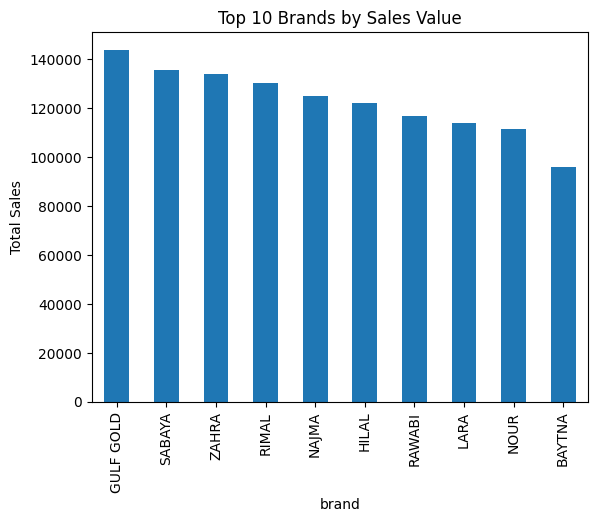

In [18]:


brand_sales.head(10)["value_sales"].plot(kind="bar")
plt.title("Top 10 Brands by Sales Value")
plt.ylabel("Total Sales")
plt.show()


<Axes: xlabel='month'>

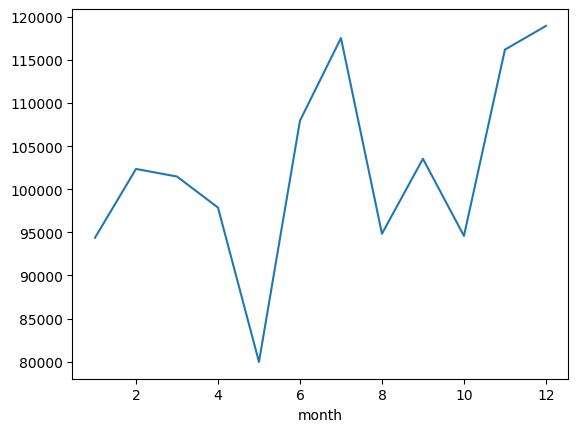

In [19]:
df.groupby('month')['value_sales'].sum().plot()


In [20]:
df.sku.unique()

array(['LARA COCONUT 0.75L TWIN PACK', 'NAJMA CANOLA 0.5L TWIN PACK',
       'BAYTNA SUNFLOWER 0.75L ECO', ..., 'LARA COCONUT 0.5L PREMIUM',
       'LARA SUNFLOWER 3L', 'NAJMA CORN 0.75L ECO'], dtype=object)

In [21]:
df.drop(['sku'], axis=1, inplace=True)

In [22]:
# Total number of order from the top 10 cities
df.groupby(['city'],as_index=False)['value_sales'].sum().sort_values(by='value_sales',ascending=False).head(10)

,city,value_sales
1,AL BAHA,143558.12
7,MAKKAH,116187.24
3,DAMMAM,104942.31
9,TABUK,104204.55
11,YANBU,101609.15
6,JEDDAH,101525.31
8,RIYADH,97394.49
5,JAZAN,95011.79
0,AL AHSA,94675.15
10,TAIF,93310.56


<Axes: xlabel='city', ylabel='value_sales'>

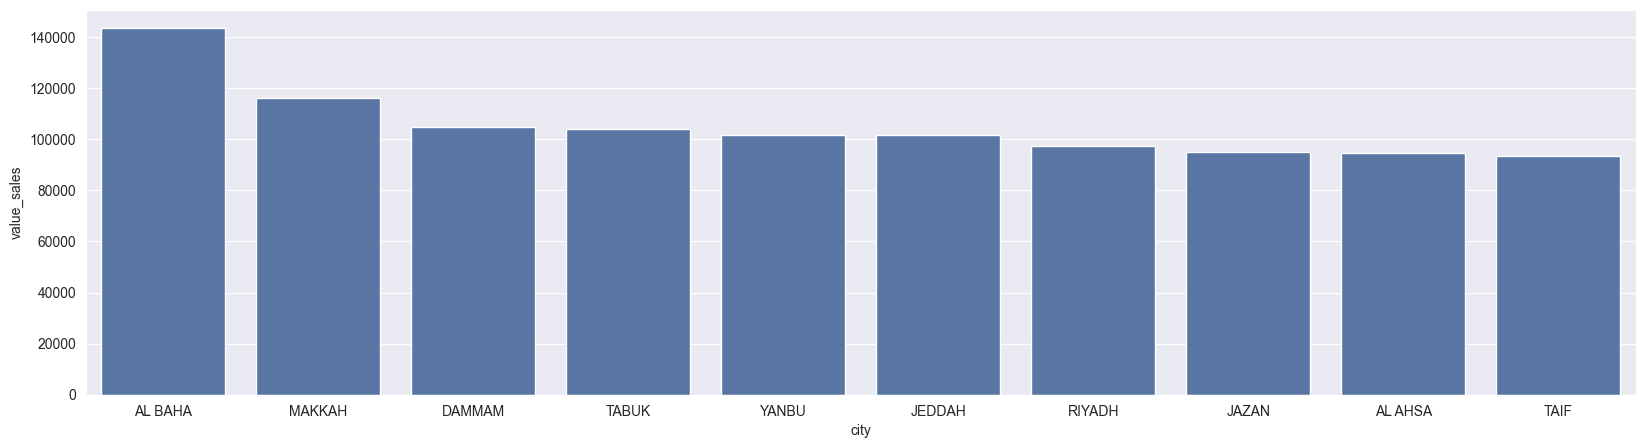

In [23]:
sales_state=df.groupby(['city'],as_index=False)['value_sales'].sum().sort_values(by='value_sales',ascending=False).head(10)
sns.set({'figure.figsize':(20,5)})
sns.barplot(data=sales_state,x='city',y='value_sales')

In [24]:
# brand vs average_price
df.groupby(['brand'],as_index=False)['average_price'].sum().sort_values(by='average_price',ascending=False).head(10)

,brand,average_price
2,HILAL,13803.34
1,GULF GOLD,13261.79
8,SABAYA,12643.22
6,RAWABI,12552.57
7,RIMAL,12485.02
4,NAJMA,12144.80
9,ZAHRA,11697.03
3,LARA,11565.04
5,NOUR,11247.66
0,BAYTNA,10579.99


<Axes: xlabel='class', ylabel='value_sales'>

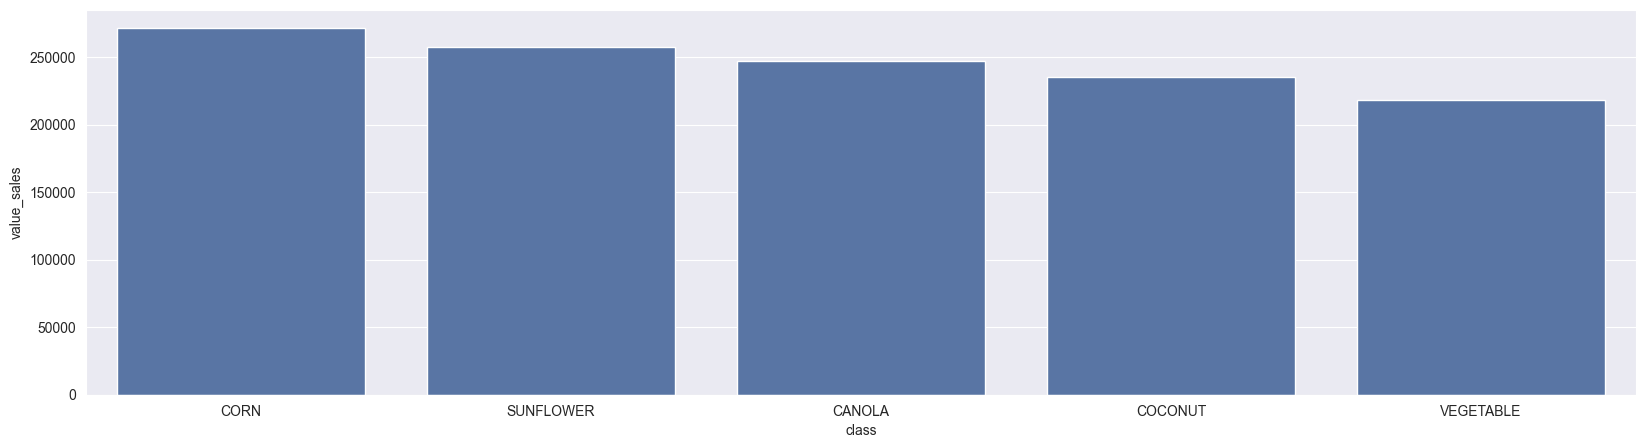

In [25]:
sales_state=df.groupby(['class'],as_index=False)['value_sales'].sum().sort_values(by='value_sales',ascending=False).head(10)
sns.set({'figure.figsize':(20,5)})
sns.barplot(data=sales_state,x='class',y='value_sales')

<Axes: xlabel='year', ylabel='value_sales'>

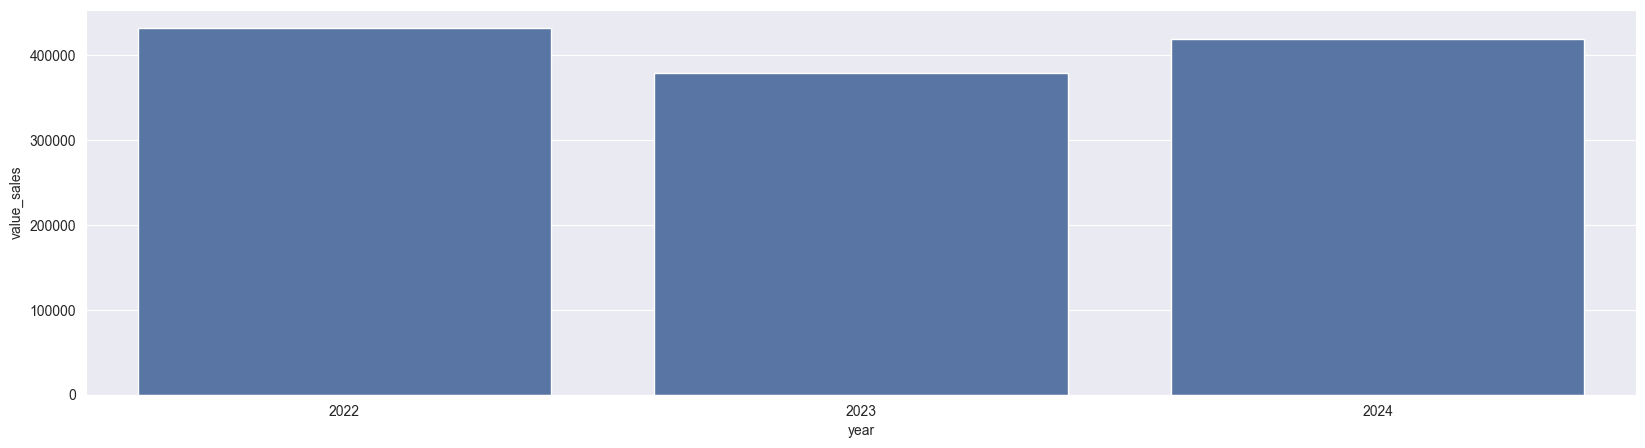

In [26]:
sales_state=df.groupby(['year'],as_index=False)['value_sales'].sum().sort_values(by='value_sales',ascending=False).head(10)
sns.set({'figure.figsize':(20,5)})
sns.barplot(data=sales_state,x='year',y='value_sales')

In [27]:
df['value_sales_log'] = np.log1p(df['value_sales'])


In [28]:
drop_cols = ['value_sales']
X = df.drop(columns=drop_cols + ['value_sales_log'])
y = df['value_sales_log']


In [30]:
cat_cols = [
    'city',
    'store_code',
    'manufacturer',
    'brand',
    'class',
    'size',
    'price_bracket'
]


encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le


In [31]:
X_train = X[df['year'] <= 2023]
X_test  = X[df['year'] == 2024]

y_train = y[df['year'] <= 2023]
y_test  = y[df['year'] == 2024]


In [ ]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=14,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=14, min_samples_leaf=5, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [33]:

# predictions (log scale -> real scale)
pred_log = model.predict(X_test)
pred_real = np.expm1(pred_log)
y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, pred_real)
mse = mean_squared_error(y_test_real, pred_real)   
rmse = np.sqrt(mse)
r2 = r2_score(y_test_real, pred_real)

print(f"MAE  : {mae:,.2f}")
print(f"RMSE : {rmse:,.2f}")
print(f"R²   : {r2:.4f}")


MAE  : 32.78
RMSE : 109.87
R²   : 0.9786


In [34]:
# Predictions in log scale
train_pred_log = model.predict(X_train)
test_pred_log  = model.predict(X_test)

# Convert back to real values
train_pred = np.expm1(train_pred_log)
y_train_real = np.expm1(y_train)

test_pred = np.expm1(test_pred_log)
y_test_real = np.expm1(y_test)


In [35]:
# Build proper time index for plotting
train_time = pd.to_datetime(
    df.loc[X_train.index, 'year'].astype(str) + '-' +
    df.loc[X_train.index, 'month'].astype(str) + '-01'
)

test_time = pd.to_datetime(
    df.loc[X_test.index, 'year'].astype(str) + '-' +
    df.loc[X_test.index, 'month'].astype(str) + '-01'
)


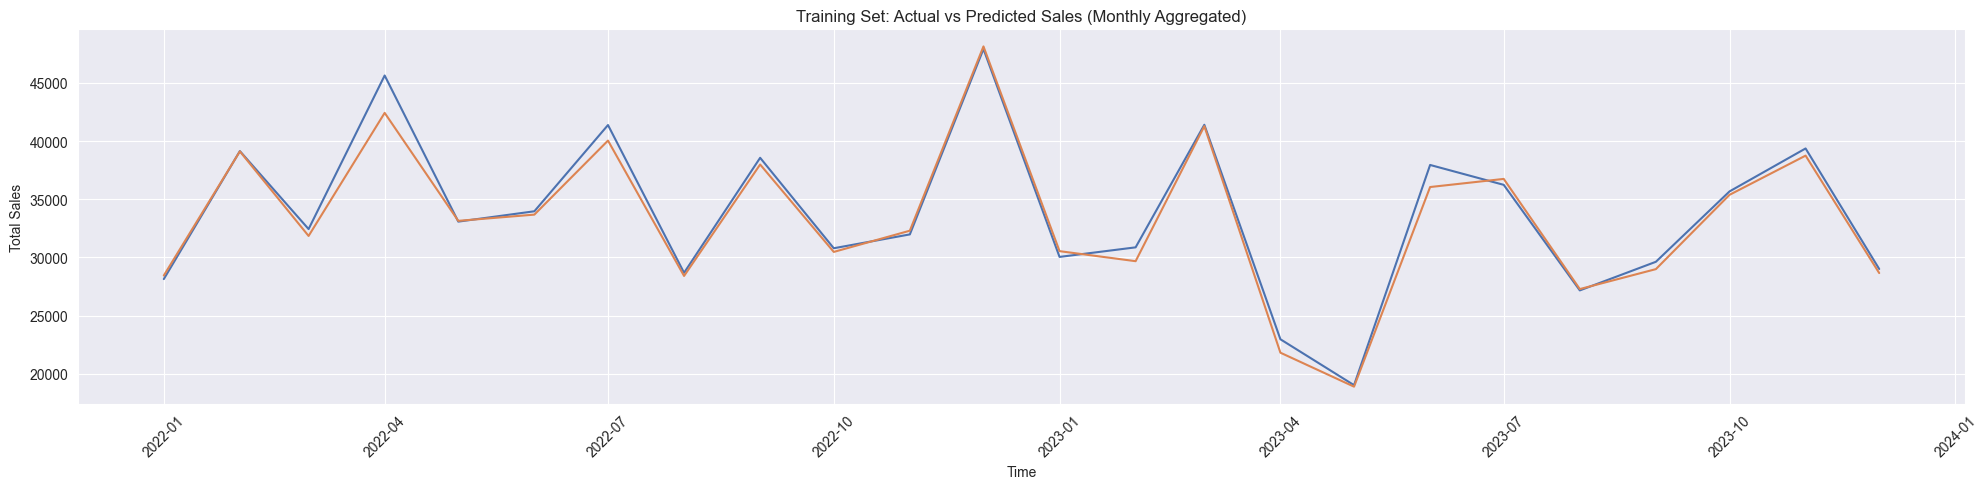

In [ ]:
train_plot = pd.DataFrame({
    "date": train_time,
    "actual": y_train_real,
    "predicted": train_pred
})

train_plot = train_plot.groupby("date").sum()

plt.figure()
plt.plot(train_plot.index, train_plot["actual"])
plt.plot(train_plot.index, train_plot["predicted"])
plt.title("Training Set: Actual vs Predicted Sales (Monthly Aggregated)")
plt.xlabel("Time")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


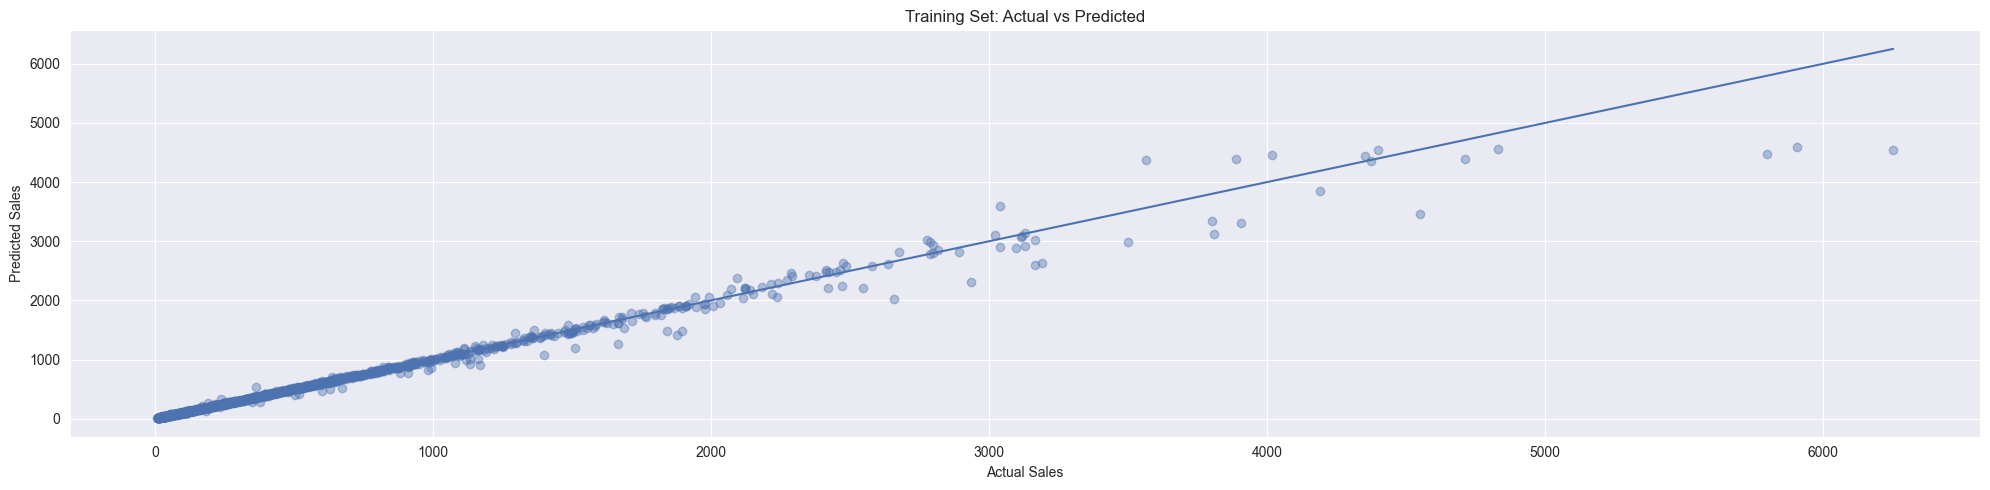

In [ ]:
plt.figure()
plt.scatter(y_train_real, train_pred, alpha=0.4)
plt.plot([y_train_real.min(), y_train_real.max()],
         [y_train_real.min(), y_train_real.max()])
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.tight_layout()
plt.show()


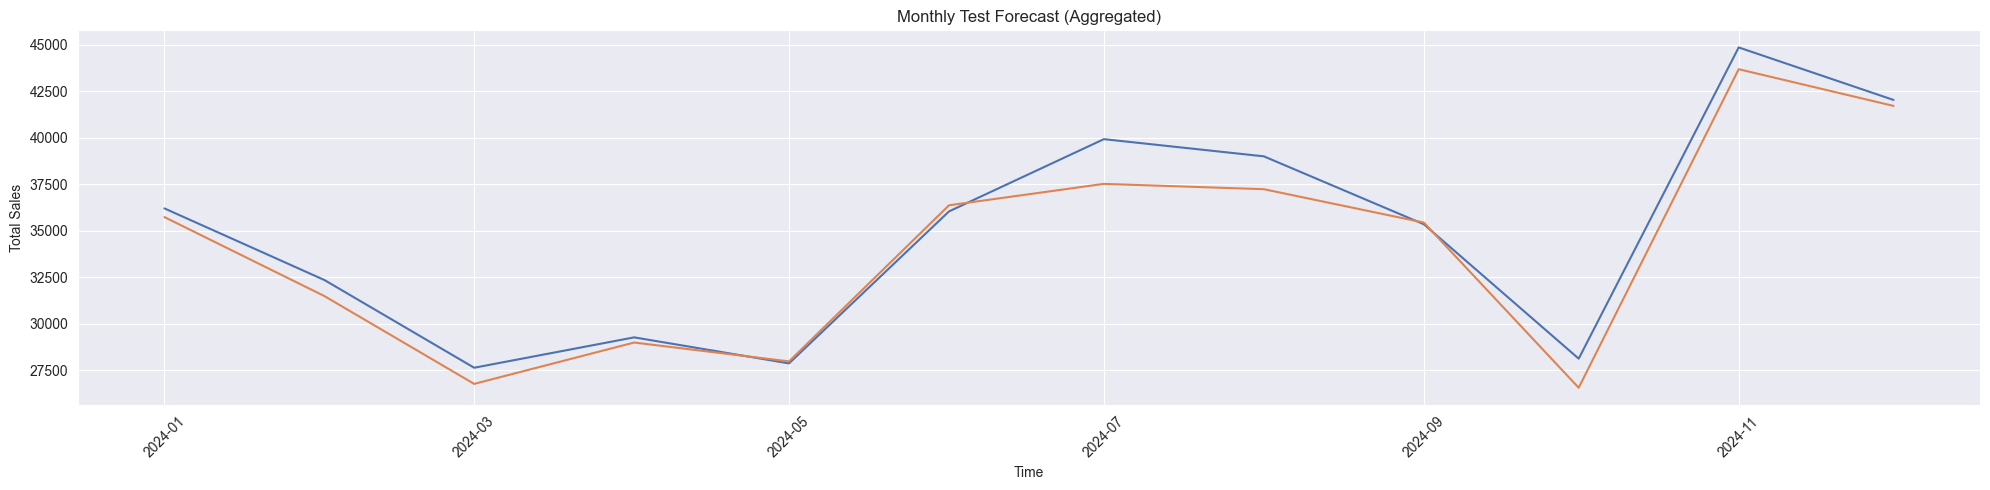

In [ ]:
plot_df = pd.DataFrame({
    'time': test_time,
    'actual': y_test_real,
    'predicted': test_pred
})

monthly_plot = plot_df.groupby('time').sum()

plt.figure()
plt.plot(monthly_plot.index, monthly_plot['actual'])
plt.plot(monthly_plot.index, monthly_plot['predicted'])
plt.title("Monthly Test Forecast (Aggregated)")
plt.xlabel("Time")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred = lr_model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

# Print results
print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"Model intercept: {lr_model.intercept_:.4f}")

# Feature importance (coefficients)
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 5 most influential features:")
print(coefficients.head(5).to_string(index=False))

R² Score: 0.7504
MSE: 0.41
RMSE: 0.64
MAE: 0.49
Model intercept: -40.1778

Top 5 most influential features:
      Feature  Coefficient
 volume_sales     0.095357
price_bracket     0.036122
         year     0.021715
average_price     0.016564
 manufacturer    -0.015370
